In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataSciece.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)




In [22]:
data = pd.read_csv('data_out/data_formatted_02.csv')
data.date = pd.to_datetime(data.date)

# add last hour values to data
data2 = data[['date', 'load','temperature', 'cloud_cover']]
data2.date = pd.to_datetime(data2.date.map(lambda x: x - pd.DateOffset(hours=-1)))
data2 = data2.rename(columns={'load':'last_hour_load', 'temperature':'last_hour_temperature', 'cloud_cover': 'last_hour_cloud_cover'})
data = data.merge(data2, on='date')

data = data.set_index('date')

In [23]:
data['day_load_mean'] = data.load.rolling(24).mean()
data['day_temperature_mean'] = data.temperature.rolling(24).mean()
features = ['temperature', 'hour', 'work', 'cloud_cover' ]
features += ['last_day_load', 'last_week_load', 'last_year_load']
features += ['day_load_mean', 'day_temperature_mean']
features += ['last_hour_cloud_cover', 'last_hour_load', 'last_hour_temperature']

## typical is all data up to 2018 is training and 2018 is test
test = data['2017-2'].append(data['2017-5']).append(data['2017-9']).append(data['2017-11']).reset_index()
training = data[:'2016'].append(data['2018']).append(data['2017-1']).append(data['2017-3':'2017-4']).append(data['2017-6':'2017-8']).append(data['2017-10']).append(data['2017-12']).reset_index()



In [24]:
training = training[features+['load']].dropna()
test2 = test[features+['load']].dropna()
x_train, y_train = training[features].values, training['load'].values
x_test, y_test = test2[features].values, test2['load'].values


In [25]:
# normalize the features - better training

mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
order = np.argsort(np.random.random(y_train.shape))
x_train = x_train[order]
y_train = y_train[order]

In [26]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(1024,
            input_shape=(x_train.shape[1],), activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1)
    ])

    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mape'])
    return model
model = build_model()
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              13312     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 1,588,225
Trainable params: 1,588,225
Non-trainable params: 0
_________________________________________________________________


In [27]:
modelSave = 'models/weights-val_5.hdf5'
EPOCHS = 10000

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=500)
save = tf.keras.callbacks.ModelCheckpoint(modelSave, monitor='val_loss', save_best_only=True)
history = model.fit(x_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, 
                    batch_size=100, verbose=2, callbacks=[earlyStop, save])


Train on 11002 samples, validate on 2751 samples
Epoch 1/10000
 - 1s - loss: 617906.6562 - mean_absolute_percentage_error: 32.2848 - val_loss: 29586.5638 - val_mean_absolute_percentage_error: 8.4235
Epoch 2/10000
 - 0s - loss: 22497.0166 - mean_absolute_percentage_error: 7.0697 - val_loss: 11308.8859 - val_mean_absolute_percentage_error: 5.0429
Epoch 3/10000
 - 0s - loss: 12744.4977 - mean_absolute_percentage_error: 5.1470 - val_loss: 7230.1681 - val_mean_absolute_percentage_error: 3.7533
Epoch 4/10000
 - 0s - loss: 9929.2397 - mean_absolute_percentage_error: 4.4687 - val_loss: 5228.4436 - val_mean_absolute_percentage_error: 3.0593
Epoch 5/10000
 - 0s - loss: 8239.9031 - mean_absolute_percentage_error: 4.0255 - val_loss: 4414.4627 - val_mean_absolute_percentage_error: 2.7888
Epoch 6/10000
 - 0s - loss: 7492.2027 - mean_absolute_percentage_error: 3.7959 - val_loss: 4893.2799 - val_mean_absolute_percentage_error: 3.0110
Epoch 7/10000
 - 0s - loss: 7261.6333 - mean_absolute_percentage_err

Epoch 57/10000
 - 0s - loss: 5430.4420 - mean_absolute_percentage_error: 3.1625 - val_loss: 3833.9081 - val_mean_absolute_percentage_error: 2.9343
Epoch 58/10000
 - 0s - loss: 5238.5519 - mean_absolute_percentage_error: 3.0959 - val_loss: 4098.6241 - val_mean_absolute_percentage_error: 3.1914
Epoch 59/10000
 - 0s - loss: 5067.3278 - mean_absolute_percentage_error: 3.0493 - val_loss: 2292.1355 - val_mean_absolute_percentage_error: 1.9161
Epoch 60/10000
 - 0s - loss: 5159.6208 - mean_absolute_percentage_error: 3.0476 - val_loss: 2511.8887 - val_mean_absolute_percentage_error: 2.1086
Epoch 61/10000
 - 0s - loss: 5341.8128 - mean_absolute_percentage_error: 3.1358 - val_loss: 2177.3111 - val_mean_absolute_percentage_error: 1.7639
Epoch 62/10000
 - 0s - loss: 5295.7353 - mean_absolute_percentage_error: 3.1348 - val_loss: 2576.0650 - val_mean_absolute_percentage_error: 2.1987
Epoch 63/10000
 - 0s - loss: 5251.1648 - mean_absolute_percentage_error: 3.1027 - val_loss: 2386.7156 - val_mean_absol

Epoch 113/10000
 - 0s - loss: 5195.2502 - mean_absolute_percentage_error: 3.0843 - val_loss: 1900.4446 - val_mean_absolute_percentage_error: 1.6433
Epoch 114/10000
 - 0s - loss: 5138.6571 - mean_absolute_percentage_error: 3.0737 - val_loss: 2503.7609 - val_mean_absolute_percentage_error: 1.8848
Epoch 115/10000
 - 0s - loss: 5064.4918 - mean_absolute_percentage_error: 3.0385 - val_loss: 2024.2024 - val_mean_absolute_percentage_error: 1.8497
Epoch 116/10000
 - 0s - loss: 4967.4483 - mean_absolute_percentage_error: 2.9926 - val_loss: 1915.1517 - val_mean_absolute_percentage_error: 1.8173
Epoch 117/10000
 - 0s - loss: 5036.5569 - mean_absolute_percentage_error: 3.0291 - val_loss: 2290.3120 - val_mean_absolute_percentage_error: 2.1241
Epoch 118/10000
 - 0s - loss: 5511.5300 - mean_absolute_percentage_error: 3.2071 - val_loss: 2201.1588 - val_mean_absolute_percentage_error: 2.0014
Epoch 119/10000
 - 0s - loss: 5427.3060 - mean_absolute_percentage_error: 3.1689 - val_loss: 1571.4959 - val_mea

Epoch 169/10000
 - 0s - loss: 5161.3391 - mean_absolute_percentage_error: 3.0956 - val_loss: 3702.9812 - val_mean_absolute_percentage_error: 2.9442
Epoch 170/10000
 - 0s - loss: 4906.7714 - mean_absolute_percentage_error: 2.9987 - val_loss: 2712.6745 - val_mean_absolute_percentage_error: 2.5196
Epoch 171/10000
 - 0s - loss: 4946.8068 - mean_absolute_percentage_error: 3.0219 - val_loss: 12768.6679 - val_mean_absolute_percentage_error: 4.6716
Epoch 172/10000
 - 0s - loss: 6349.4164 - mean_absolute_percentage_error: 3.4048 - val_loss: 1866.5351 - val_mean_absolute_percentage_error: 1.6534
Epoch 173/10000
 - 0s - loss: 4727.9017 - mean_absolute_percentage_error: 2.9068 - val_loss: 1858.7496 - val_mean_absolute_percentage_error: 1.8238
Epoch 174/10000
 - 0s - loss: 5077.2885 - mean_absolute_percentage_error: 3.0624 - val_loss: 1555.2889 - val_mean_absolute_percentage_error: 1.5220
Epoch 175/10000
 - 0s - loss: 5027.6799 - mean_absolute_percentage_error: 3.0521 - val_loss: 6271.1144 - val_me

Epoch 225/10000
 - 0s - loss: 4655.7642 - mean_absolute_percentage_error: 2.9348 - val_loss: 4114.5420 - val_mean_absolute_percentage_error: 3.3759
Epoch 226/10000
 - 0s - loss: 5104.5191 - mean_absolute_percentage_error: 3.1215 - val_loss: 1294.9795 - val_mean_absolute_percentage_error: 1.2893
Epoch 227/10000
 - 0s - loss: 4542.9963 - mean_absolute_percentage_error: 2.8924 - val_loss: 1638.6914 - val_mean_absolute_percentage_error: 1.7076
Epoch 228/10000
 - 0s - loss: 4518.6914 - mean_absolute_percentage_error: 2.8831 - val_loss: 2361.5461 - val_mean_absolute_percentage_error: 1.8927
Epoch 229/10000
 - 0s - loss: 4788.0832 - mean_absolute_percentage_error: 2.9715 - val_loss: 1686.0386 - val_mean_absolute_percentage_error: 1.7289
Epoch 230/10000
 - 0s - loss: 4446.0039 - mean_absolute_percentage_error: 2.8894 - val_loss: 1822.1958 - val_mean_absolute_percentage_error: 1.8655
Epoch 231/10000
 - 0s - loss: 4548.0311 - mean_absolute_percentage_error: 2.9136 - val_loss: 2362.6686 - val_mea

Epoch 281/10000
 - 0s - loss: 4521.3196 - mean_absolute_percentage_error: 2.9187 - val_loss: 1635.5889 - val_mean_absolute_percentage_error: 1.4543
Epoch 282/10000
 - 0s - loss: 4463.4399 - mean_absolute_percentage_error: 2.8968 - val_loss: 1999.1486 - val_mean_absolute_percentage_error: 1.8799
Epoch 283/10000
 - 0s - loss: 4582.7591 - mean_absolute_percentage_error: 2.9493 - val_loss: 1873.8395 - val_mean_absolute_percentage_error: 1.7658
Epoch 284/10000
 - 0s - loss: 4428.9006 - mean_absolute_percentage_error: 2.8908 - val_loss: 1565.7204 - val_mean_absolute_percentage_error: 1.3653
Epoch 285/10000
 - 0s - loss: 4669.5107 - mean_absolute_percentage_error: 2.9255 - val_loss: 2460.9856 - val_mean_absolute_percentage_error: 1.8821
Epoch 286/10000
 - 0s - loss: 4389.2201 - mean_absolute_percentage_error: 2.8509 - val_loss: 2339.9223 - val_mean_absolute_percentage_error: 2.0875
Epoch 287/10000
 - 0s - loss: 4638.8409 - mean_absolute_percentage_error: 2.9373 - val_loss: 2080.0784 - val_mea

Epoch 337/10000
 - 0s - loss: 4393.8659 - mean_absolute_percentage_error: 2.8602 - val_loss: 1625.0949 - val_mean_absolute_percentage_error: 1.4298
Epoch 338/10000
 - 0s - loss: 4443.8298 - mean_absolute_percentage_error: 2.8563 - val_loss: 1969.1461 - val_mean_absolute_percentage_error: 1.5969
Epoch 339/10000
 - 0s - loss: 4412.4063 - mean_absolute_percentage_error: 2.8565 - val_loss: 1670.1667 - val_mean_absolute_percentage_error: 1.5632
Epoch 340/10000
 - 0s - loss: 4641.3934 - mean_absolute_percentage_error: 2.9566 - val_loss: 4269.3134 - val_mean_absolute_percentage_error: 3.4250
Epoch 341/10000
 - 0s - loss: 5184.9116 - mean_absolute_percentage_error: 3.1303 - val_loss: 2700.9592 - val_mean_absolute_percentage_error: 2.1493
Epoch 342/10000
 - 0s - loss: 4454.5056 - mean_absolute_percentage_error: 2.9002 - val_loss: 1790.6308 - val_mean_absolute_percentage_error: 1.5795
Epoch 343/10000
 - 0s - loss: 4299.6363 - mean_absolute_percentage_error: 2.8504 - val_loss: 2341.3183 - val_mea

Epoch 393/10000
 - 0s - loss: 4451.0900 - mean_absolute_percentage_error: 2.8687 - val_loss: 1817.4805 - val_mean_absolute_percentage_error: 1.3831
Epoch 394/10000
 - 0s - loss: 4415.8128 - mean_absolute_percentage_error: 2.8732 - val_loss: 2647.8066 - val_mean_absolute_percentage_error: 2.1993
Epoch 395/10000
 - 0s - loss: 4483.5958 - mean_absolute_percentage_error: 2.9091 - val_loss: 6657.5483 - val_mean_absolute_percentage_error: 4.2839
Epoch 396/10000
 - 0s - loss: 5950.3958 - mean_absolute_percentage_error: 3.2715 - val_loss: 2088.9995 - val_mean_absolute_percentage_error: 1.4328
Epoch 397/10000
 - 0s - loss: 4665.0443 - mean_absolute_percentage_error: 2.9209 - val_loss: 2835.1516 - val_mean_absolute_percentage_error: 2.2538
Epoch 398/10000
 - 0s - loss: 4504.6865 - mean_absolute_percentage_error: 2.9136 - val_loss: 2209.6742 - val_mean_absolute_percentage_error: 1.8767
Epoch 399/10000
 - 0s - loss: 4401.2679 - mean_absolute_percentage_error: 2.8593 - val_loss: 2012.3990 - val_mea

Epoch 449/10000
 - 0s - loss: 4348.8898 - mean_absolute_percentage_error: 2.8806 - val_loss: 2673.7426 - val_mean_absolute_percentage_error: 1.9195
Epoch 450/10000
 - 0s - loss: 4369.7631 - mean_absolute_percentage_error: 2.8786 - val_loss: 2347.7017 - val_mean_absolute_percentage_error: 1.7750
Epoch 451/10000
 - 0s - loss: 4601.2500 - mean_absolute_percentage_error: 2.9675 - val_loss: 5502.6106 - val_mean_absolute_percentage_error: 3.3015
Epoch 452/10000
 - 0s - loss: 4551.7023 - mean_absolute_percentage_error: 2.9431 - val_loss: 2585.0609 - val_mean_absolute_percentage_error: 1.9590
Epoch 453/10000
 - 0s - loss: 4624.4178 - mean_absolute_percentage_error: 2.9700 - val_loss: 1597.3167 - val_mean_absolute_percentage_error: 1.2150
Epoch 454/10000
 - 0s - loss: 4176.0480 - mean_absolute_percentage_error: 2.7911 - val_loss: 2020.7715 - val_mean_absolute_percentage_error: 1.5917
Epoch 455/10000
 - 0s - loss: 4322.2558 - mean_absolute_percentage_error: 2.8729 - val_loss: 1693.1934 - val_mea

Epoch 505/10000
 - 0s - loss: 4376.5718 - mean_absolute_percentage_error: 2.8540 - val_loss: 2710.7382 - val_mean_absolute_percentage_error: 1.7780
Epoch 506/10000
 - 0s - loss: 4894.8375 - mean_absolute_percentage_error: 3.0189 - val_loss: 3421.5515 - val_mean_absolute_percentage_error: 2.5058
Epoch 507/10000
 - 0s - loss: 4541.5510 - mean_absolute_percentage_error: 2.9128 - val_loss: 2524.2509 - val_mean_absolute_percentage_error: 2.0148
Epoch 508/10000
 - 0s - loss: 4296.0138 - mean_absolute_percentage_error: 2.8352 - val_loss: 5762.2087 - val_mean_absolute_percentage_error: 3.1413
Epoch 509/10000
 - 0s - loss: 5238.9306 - mean_absolute_percentage_error: 3.1297 - val_loss: 2217.6075 - val_mean_absolute_percentage_error: 1.6380
Epoch 510/10000
 - 0s - loss: 4148.7548 - mean_absolute_percentage_error: 2.7879 - val_loss: 1961.1582 - val_mean_absolute_percentage_error: 1.5661
Epoch 511/10000
 - 0s - loss: 4262.3061 - mean_absolute_percentage_error: 2.8287 - val_loss: 1673.1700 - val_mea

Epoch 561/10000
 - 0s - loss: 4232.4972 - mean_absolute_percentage_error: 2.8587 - val_loss: 2819.8443 - val_mean_absolute_percentage_error: 2.0666
Epoch 562/10000
 - 0s - loss: 4267.4612 - mean_absolute_percentage_error: 2.8104 - val_loss: 3877.1220 - val_mean_absolute_percentage_error: 2.3596
Epoch 563/10000
 - 0s - loss: 4713.6334 - mean_absolute_percentage_error: 2.9729 - val_loss: 5147.2137 - val_mean_absolute_percentage_error: 3.3934
Epoch 564/10000
 - 0s - loss: 4538.8487 - mean_absolute_percentage_error: 2.9318 - val_loss: 3290.8854 - val_mean_absolute_percentage_error: 2.0156
Epoch 565/10000
 - 0s - loss: 4681.1852 - mean_absolute_percentage_error: 3.0012 - val_loss: 2563.6210 - val_mean_absolute_percentage_error: 1.9172
Epoch 566/10000
 - 0s - loss: 4244.5508 - mean_absolute_percentage_error: 2.8418 - val_loss: 1792.9384 - val_mean_absolute_percentage_error: 1.3264
Epoch 567/10000
 - 0s - loss: 4275.0828 - mean_absolute_percentage_error: 2.8247 - val_loss: 3495.3118 - val_mea

Epoch 617/10000
 - 0s - loss: 4148.2888 - mean_absolute_percentage_error: 2.7949 - val_loss: 2104.6179 - val_mean_absolute_percentage_error: 1.5263
Epoch 618/10000
 - 0s - loss: 4270.7363 - mean_absolute_percentage_error: 2.8561 - val_loss: 1822.8458 - val_mean_absolute_percentage_error: 1.3507
Epoch 619/10000
 - 0s - loss: 4285.0053 - mean_absolute_percentage_error: 2.8344 - val_loss: 3624.8923 - val_mean_absolute_percentage_error: 2.4347
Epoch 620/10000
 - 0s - loss: 4418.8795 - mean_absolute_percentage_error: 2.9172 - val_loss: 1715.8557 - val_mean_absolute_percentage_error: 1.2254
Epoch 621/10000
 - 0s - loss: 4191.0959 - mean_absolute_percentage_error: 2.8206 - val_loss: 2088.7231 - val_mean_absolute_percentage_error: 1.4734
Epoch 622/10000
 - 0s - loss: 4059.2114 - mean_absolute_percentage_error: 2.7653 - val_loss: 1869.6484 - val_mean_absolute_percentage_error: 1.3841
Epoch 623/10000
 - 0s - loss: 4314.4364 - mean_absolute_percentage_error: 2.8634 - val_loss: 1943.4417 - val_mea

Epoch 673/10000
 - 0s - loss: 4576.5219 - mean_absolute_percentage_error: 2.9352 - val_loss: 2295.7985 - val_mean_absolute_percentage_error: 1.8368
Epoch 674/10000
 - 0s - loss: 4157.3027 - mean_absolute_percentage_error: 2.8158 - val_loss: 1634.3232 - val_mean_absolute_percentage_error: 1.2749
Epoch 675/10000
 - 0s - loss: 4270.1191 - mean_absolute_percentage_error: 2.8685 - val_loss: 1931.6428 - val_mean_absolute_percentage_error: 1.4192
Epoch 676/10000
 - 0s - loss: 4104.6567 - mean_absolute_percentage_error: 2.7933 - val_loss: 1802.2987 - val_mean_absolute_percentage_error: 1.3229
Epoch 677/10000
 - 0s - loss: 4379.9682 - mean_absolute_percentage_error: 2.8693 - val_loss: 1677.3550 - val_mean_absolute_percentage_error: 1.2844
Epoch 678/10000
 - 0s - loss: 4127.8437 - mean_absolute_percentage_error: 2.7853 - val_loss: 2187.4798 - val_mean_absolute_percentage_error: 1.6602
Epoch 679/10000
 - 0s - loss: 4394.4743 - mean_absolute_percentage_error: 2.8633 - val_loss: 1647.2087 - val_mea

In [28]:
[loss,mpe] = model.evaluate(x_test, y_test, verbose=0)

print("Testing set Mean Abs percent Error: {:7.2f}".format(mpe))
model2 = tf.keras.models.load_model(modelSave)
[loss2,mpe2] = model2.evaluate(x_test, y_test, verbose=0)
print("Testing set Mean Abs best percent Error: {:7.2f}".format(mpe2))

Testing set Mean Abs percent Error:    2.49
Testing set Mean Abs best percent Error:    1.18


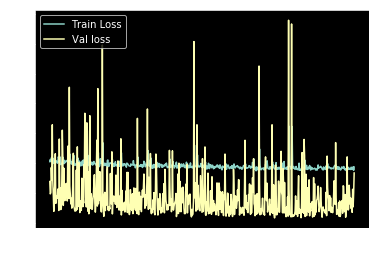

In [29]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch[100:], np.array(history.history['mean_absolute_percentage_error'][100:]),
           label='Train Loss')
    plt.plot(history.epoch[100:], np.array(history.history['val_mean_absolute_percentage_error'][100:]),
           label = 'Val loss')
    plt.legend()
    plt.show()
plot_history(history)


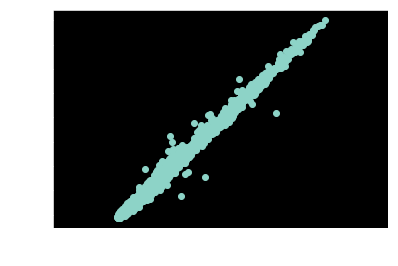

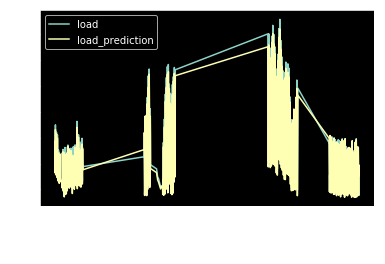

In [30]:
test_predictions = model.predict(x_test).flatten()
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

test = test[features+['load', 'date']].dropna()
test['load_prediction'] = test_predictions
test.plot(x='date', y=['load','load_prediction'], legend=True)
plt.show()